<a href="https://colab.research.google.com/github/HughYau/RUC-Dynamic-Optimizaton/blob/main/10_25_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from textwrap import dedent
import numpy as np
from scipy.stats import norm
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler

## 离散化AR（1）过程 （Discretizing an Autoregressive Process with a Markov Chain）
回顾一下我们之前学过的离散蛋糕选择模型（Stochastic Discrete Cake-Eating Problem）：

你需要选择什么时候去选择吃蛋糕，以最大化自己的效用：
$$ \underset{\{{E}, {N}\}} {max} \;\  V(W, \;\ {\epsilon})  $$

$V$是一个值函数，其满足贝尔曼方程： $$ V(W, \;\  {\epsilon}) = max\{{\epsilon}  u(W), \;\  \beta \underset{{\epsilon}{{'}} | {\epsilon}} E[V(\rho W, \;\ {\epsilon}')]\} $$
其中 $\epsilon$ 是一个冲击（shock）。

这里的冲击，我们通常认为是一个AR（1）过程，满足:
$$
\epsilon_t - \mu = \rho(\epsilon_{t-1}-\mu)+u_t
$$
其中：$\mu$是均值，$\rho$是自相关系数。

这个过程代入值函数模拟是非常复杂的，因为理论上他会有无穷种情况，一个比较常见的作法是将其离散化成多个状态，并给出不同状态之间的转移概率。

即，如何将一个AR（1）过程离散化成马尔可夫链。

通常采用的是Tauchen（1986）给出的方法。

In [ ]:
class CakeEating(object):
    def __init__(self, beta=0.95, r = 0.95, gamma = 1, logutil=False,
                     transition = [[1, 0], [0, 1]], shocks=[.8, 1.2],
                     grid_max=2, grid_min = .4, grid_size=150):

        self.r, self.beta, self.gamma = r, beta, gamma
        self.transition = transition
        self.shocks = shocks

        if logutil == False:
            self.u = lambda c: (c**(1 - gamma))/(1 - gamma)
        else:
            self.u = np.log
            self.gamma = 1
        self.grid = np.linspace(grid_min, grid_max, grid_size)
        
    def bellman_operator(self, w, compute_policy=False):

        Aw = [InterpolatedUnivariateSpline(self.grid, w[i], k=3) for i in range(len(self.shocks))]
        Awx = lambda y: np.asarray([function(y) for function in Aw]) 
        sigma = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        flag = np.asarray([np.empty(len(w[0]))]*len(self.shocks))

        for i, x in enumerate(self.grid):
            for j, e in enumerate(self.shocks):
                u_now = self.u(e*x)
                u_wait  = self.beta*np.dot(self.transition[j], Awx(self.r*x))
                Tw[j][i] = max(u_now, u_wait)
                if u_now > u_wait:
                  flag[j][i] = 1
                else:
                  flag[j][i] = 0
                sigma[j][i] = np.exp(u_wait - self.u(x))

        return Tw,sigma,flag

    def plot(self):
        w_guess = np.asarray([np.log(self.grid)]*len(self.shocks))
        w_star = compute_fixed_point(self.bellman_operator, w_guess, max_iter=100000, verbose=1, error_tol=1e-3, print_skip=10)
        sigma_star = self.bellman_operator(w_star)[1]
        flag_star = self.bellman_operator(w_star)[2]

        fig, ax = plt.subplots(3, 1, figsize =(8,15))
        ax[0].set_xlabel("Cake Size")
        ax[1].set_xlabel("Cake Size")
        ax[2].set_xlabel("Cake Size")
        ax[0].set_ylabel("Value Function")
        ax[1].set_ylabel("Threshold Shock")
        ax[2].set_ylabel("Policy Function")
        eating = [self.u(self.grid)*self.shocks[i] - .1  for i in range(len(self.shocks))] 
                                                                              


        labels = [r'Shock {0:.2g}'.format(self.shocks[k]) for k in range(len(self.shocks))] 
        for i in range(len(self.shocks)):
            ax[0].plot(self.grid, w_star[i], lw = 2, alpha = .8, label= labels[i])
            ax[2].plot(self.grid, flag_star[i], lw = 2, alpha = .8, label= labels[i])

        ax[1].plot(self.grid, sigma_star[0], 'k-', lw = 2, alpha = .8)
        ax[0].legend(loc = 'lower right')
        ax[2].legend(loc = 'middle right')
        t = 'Discrete Choice - Cake Problem'
        fig.suptitle(t, fontsize=18)

        plt.show()

In [ ]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,
                            print_skip=25,verbose=True):#迭代计算
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v)[0]
            i += 1
            error = np.max(np.abs(new_v - v))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛")


        return v

In [ ]:
def approx_markov(rho, sigma_u, m=3, n=7):
        F = norm(loc=0, scale=sigma_u).cdf

        # standard deviation of y_t
        std_y = np.sqrt(sigma_u**2 / (1-rho**2))
        # top of discrete state space
        x_max = m * std_y
        # bottom of discrete state space
        x_min = - x_max
        # discretized state space
        x = np.linspace(x_min, x_max, n)

        step = (x_max - x_min) / (n - 1)
        half_step = 0.5 * step
        P = np.empty((n, n))

        for i in range(n):
            P[i, 0] = F(x[0]-rho * x[i] + half_step)
            P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
            for j in range(1, n-1):
                z = x[j] - rho * x[i]
                P[i, j] = F(z + half_step) - F(z - half_step)

        return x, P

In [ ]:
epsilon, trans = approx_markov(rho = .5, sigma_u=.2, n = 4, m=1.3)
shocklist = np.exp(epsilon)
discount = .95 
shrink_rate = .95 


gmin = .5
gmax = 10
print(trans,shocklist)

[[0.4012221  0.37231775 0.18651267 0.03994748]
 [0.22646015 0.37231775 0.29574128 0.10548081]
 [0.10548081 0.29574128 0.37231775 0.22646015]
 [0.03994748 0.18651267 0.37231775 0.4012221 ]] [0.74065367 0.90477042 1.10525276 1.3501587 ]


第 10步收敛结果是  0.009055895433298322.
第 20步收敛结果是  0.005693472178790515.
第 30步收敛结果是  0.002876915324779683.
第 40步收敛结果是  0.0009084317534090447.

在第 40 步收敛


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Unrecognized location 'middle right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


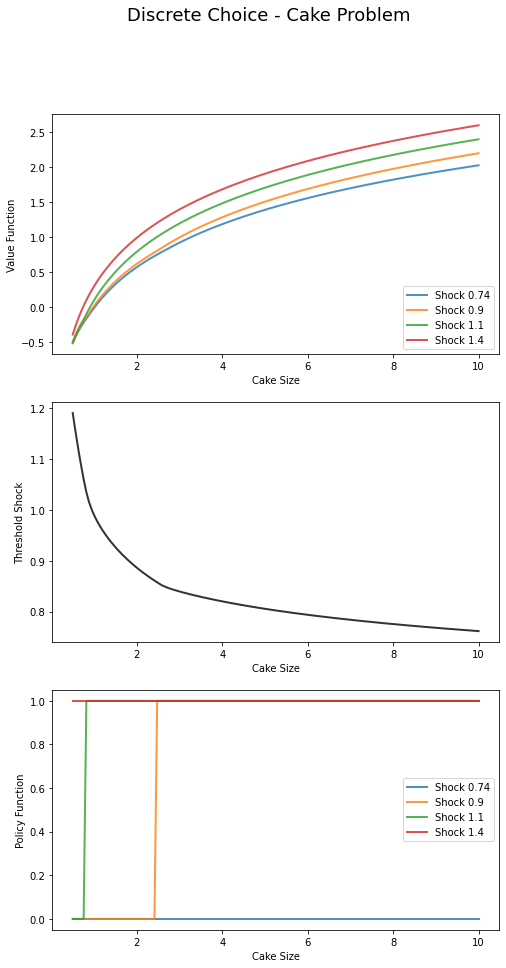

In [ ]:
cp = CakeEating(logutil=True, transition=trans, grid_min=gmin, grid_max=gmax, 
                          shocks=shocklist, r=shrink_rate, beta=discount)
cp.plot()